# Analyse ERA5 weather model data

**GRIB format**
* pygrib
* xarray (cfgrib)

**NETCDF format**
* netCDF4

In [352]:
%load_ext autoreload
%autoreload 2
import numpy as np
import pandas as pd
import cartopy
import matplotlib.pyplot as plt
import plotly.express as px

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Analysing GRIB file with pygrib

In [170]:
import pygrib # alternative: use cfgrib (see below)
import time

In [203]:
tic = time.perf_counter()
grbs = pygrib.open("wind_2020_62.0,10.75.grib")
toc = time.perf_counter()
print(f"It took {toc-tic} seconds")

It took 1.9628633000102127 seconds


In [205]:
grbs.seek(0)
#for grb in grbs:
    #print(grb)

In [206]:
v1=grbs[1]

In [213]:
gg=grbs.select()

In [224]:
gg[5].time

2300

In [563]:
#grbs = pygrib.open('test.grb')
#grbs = pygrib.open('surface.grb')
grbs = pygrib.open('surface_singlelevel.grb')

In [195]:
grbs.seek(0)
for grb in grbs:
    timestr="{}-{:02d}-{:02d} {:02d}:{:02}".format(
        grb.year,grb.month,grb.day,grb.hour,grb.minute)
    print(timestr)
grbs.seek(0)
grb = grbs.select()[0]

2020-01-01 00:00
2020-01-01 00:00
2020-01-01 00:00
2020-01-01 00:00


In [578]:
timestr="{}-{:02d}-{:02d} {:02d}:{:02}".format(
    grb.year,grb.month,grb.day,grb.hour,grb.minute)

In [196]:
print(grb)
print(grbs.select()[-1])

1:100 metre U wind component:m s**-1 (instant):regular_ll:surface:level 0:fcst time 0 hrs:from 202001010000
4:10 metre V wind component:m s**-1 (instant):regular_ll:surface:level 0:fcst time 0 hrs:from 202001010000


In [197]:
# Alt 1:
df = pd.DataFrame(np.reshape(grb['latLonValues'],(3,-1),order='F')).T
df.columns = ['lat','lon','value']
#df=df.set_index(['lat','lon']) # change to matrix, for contour plotting
# Alt 2:
df2=pd.DataFrame()
df2['lat'] = grb['latitudes']
df2['lon'] = grb['longitudes']
df2['value'] = grb.values.ravel()
#df2=df2.set_index(['lat','lon']) # change to matrix, for contour plotting
# Alt 3:
df3=pd.DataFrame(index=grb['distinctLatitudes'],
                 columns=grb['distinctLongitudes'],
                 data=grb.values)
#df3=df3.stack().reset_index().head() # change to long array (3 columns)
#df3.columns=['lat','lon','value']

In [198]:
df.head()

lat   lon    value
0  90.0  0.00 -0.54512
1  90.0  0.25 -0.54512
2  90.0  0.50 -0.54512
3  90.0  0.75 -0.54512
4  90.0  1.00 -0.54512

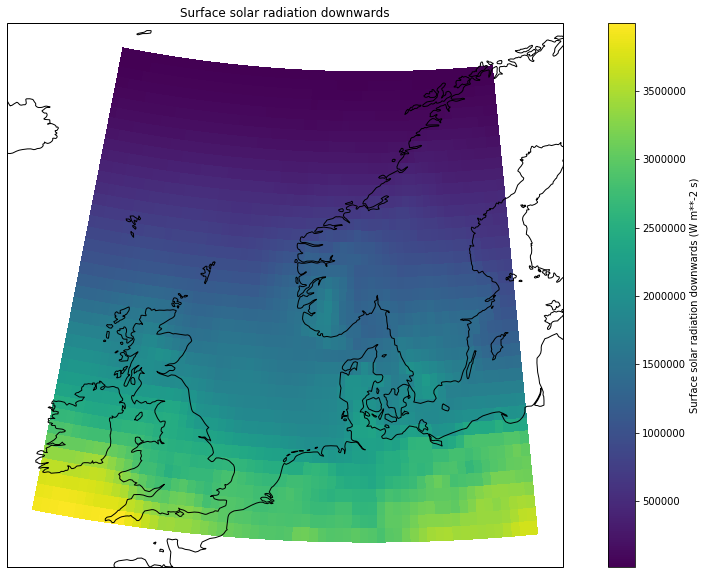

In [568]:
plt.figure(figsize=(16,10))
#proj=cartopy.crs.Mercator(central_longitude=5)
#proj=cartopy.crs.LambertAzimuthalEqualArea(central_longitude=10,central_latitude=60)
proj=cartopy.crs.AlbersEqualArea(central_longitude=10,central_latitude=60)
#proj=cartopy.crs.PlateCarree()
ax = plt.subplot(111, projection=proj)
#mm = ax.pcolormesh(grb['distinctLongitudes'],grb['distinctLatitudes'],
#                   grb.values,transform=cartopy.crs.PlateCarree())
mm = ax.pcolormesh(df3.columns,df3.index,df3,transform=cartopy.crs.PlateCarree())
#ax.scatter(df['lon'],df['lat'],s=1,c=df['value'],zorder=3,transform=cartopy.crs.PlateCarree())
cbar=plt.colorbar(mm,ax=ax,label="{} ({})".format(grb.parameterName,grb.parameterUnits))
#ax.contourf(grb['distinctLongitudes'],grb['distinctLatitudes'],grb.values,60)
ax.coastlines(resolution='50m')
#ax.gridlines(draw_labels=False)
plt.title(grb.parameterName)
plt.show()

In [560]:
for k in grb.keys():
    print("{}: {}".format(k, getattr(grb,k)))

globalDomain: g
GRIBEditionNumber: 1
eps: 0
offsetSection0: 0
section0Length: 8
totalLength: 5114
editionNumber: 1
WMO: 0
productionStatusOfProcessedData: 0
section1Length: 56
wrongPadding: 0
table2Version: 128
centre: ecmf
centreDescription: European Centre for Medium-Range Weather Forecasts
generatingProcessIdentifier: 145
gridDefinition: 255
indicatorOfParameter: 169
parameterName: Surface solar radiation downwards
parameterUnits: W m**-2 s
indicatorOfTypeOfLevel: sfc
pressureUnits: hPa
typeOfLevelECMF: surface
typeOfLevel: surface
level: 0
yearOfCentury: 9
month: 12
day: 31
hour: 18
minute: 0
second: 0
unitOfTimeRange: 1
P1: 0
P2: 12
timeRangeIndicator: 130
numberIncludedInAverage: 248
numberMissingFromAveragesOrAccumulations: 0
centuryOfReferenceTimeOfData: 21
subCentre: 0
paramIdECMF: 169
paramId: 169
cfNameECMF: surface_downwelling_shortwave_flux_in_air
cfName: surface_downwelling_shortwave_flux_in_air
cfVarNameECMF: ssrd
cfVarName: ssrd
unitsECMF: J m**-2
units: J m**-2
nameECM

## GRIB format with cfgrib

In [44]:
# this seems necessary to avoid error message:
%env ECCODES_DEFINITION_PATH=C:/Users/hsven/Miniconda3/envs/timeseries/Library/share/eccodes/definitions
import xarray as xr
import itertools
#import geopandas
#import shapely
#import geoplot

env: ECCODES_DEFINITION_PATH=C:/Users/hsven/Miniconda3/envs/timeseries/Library/share/eccodes/definitions


In [248]:
ds = xr.open_dataset('surface_singlelevel.grb', engine='cfgrib')
#ds = xr.open_dataset('surface.grb', engine='cfgrib')
#ds = xr.open_dataset("wind_2020_62.0,10.75.grib",engine="cfgrib")
#ds2=xr.Dataset()

DatasetBuildError: multiple values for unique key, try re-open the file with one of:
    filter_by_keys={'numberOfPoints': 2501}
    filter_by_keys={'numberOfPoints': 9801}

In [163]:
xr.open_dataarray("wind_2020_62.0,10.75.grib")

IndexError: too many indices for array: array is 0-dimensional, but 1 were indexed

In [143]:
my_lat = 62.1
my_lon = 10.87
find_nearest_datapoint(my_lat,my_lon,ds)

(62.0, 10.75)

### Illustrate data grid

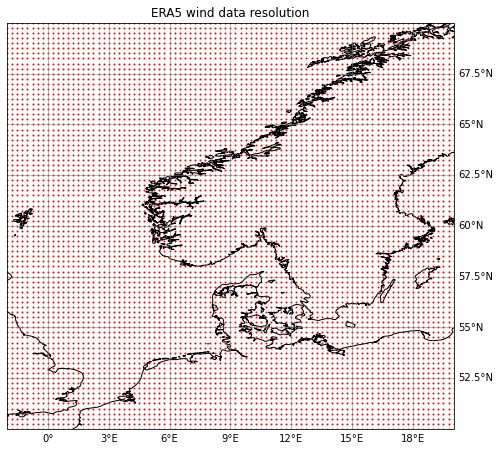

In [145]:
lats=ds.coords.indexes["latitude"]
lons=ds.coords.indexes["longitude"]
xx,yy=np.meshgrid(lons,lats)
proj = cartopy.crs.PlateCarree()
plt.figure(figsize=(8,8))
ax = plt.axes(projection=proj,extent=[-2, 20, 50, 70])
plt.title('ERA5 wind data resolution')
ax.coastlines(resolution='10m')
if isinstance(proj,cartopy.crs.PlateCarree):
    gl = ax.gridlines(crs=proj, draw_labels=True,
        linewidth=1, color='gray', alpha=0.5, linestyle='-')
    gl.top_labels = False
    gl.left_labels = False
coords=np.outer(lats,lons)
plt.scatter(xx,yy,s=1,marker="o",color="red",transform=cartopy.crs.Geodetic())
plt.show()

In [5]:
#ds
#ds.step.values/(3600*1e9)
#ds.t2m.isel(step=1).values

In [6]:
ssrd_0=ds.ssrd.isel(step=0)
t_date=ds.time.values
t_hours=ds.step.values/(3600*1e9)
@widgets.interact
def show_rad(hour=(t_hours[0],t_hours[-1],1)):
    step=hour-t_hours[0]
    ssrd_1=(ds.ssrd.isel(step=step)-ssrd_0)/3600
    #ssrd_1=ds.t2m.isel(step=step)-273.15 #K to C
    #ssrd_1=ds.v10.isel(step=step)
    ssrd_1.plot(figsize=(12,10))

AttributeError: 'Dataset' object has no attribute 'ssrd'

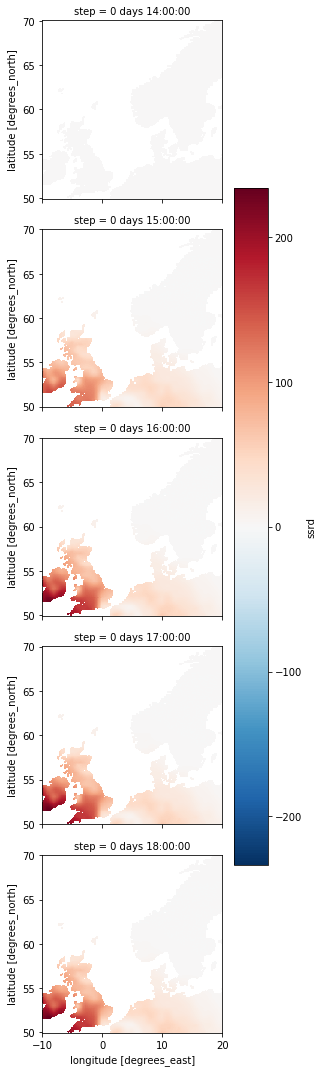

In [68]:
ssrd_t=(ds.ssrd-ssrd_0)/3600
ssrd_t.plot(x='longitude',y='latitude',row='step')

## NetCDF format

In [47]:
import netCDF4
import ipywidgets as widgets
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import geopandas
import geoplot
import shapely
import itertools
#from ipywidgets import interact, interact_manual

In [2]:
nc_rad = netCDF4.Dataset('test2.nc')

In [3]:
# longitude, latitude, time, ssrd
times=nc_rad.variables['time']
jd = netCDF4.num2date(times[:],times.units)
lats = nc_rad.variables['latitude'][:]
lons = nc_rad.variables['longitude'][:]
ssrd = nc_rad.variables['ssrd']

In [100]:
ssrd.units

'J m**-2'

In [17]:
print(nc_rad.variables.keys())
nc_rad.variables["ssrd"]

dict_keys(['longitude', 'latitude', 'time', 'ssrd'])


<class 'netCDF4._netCDF4.Variable'>
int16 ssrd(time, latitude, longitude)
    scale_factor: 30.08731478796942
    add_offset: 985840.956342606
    _FillValue: -32767
    missing_value: -32767
    units: J m**-2
    long_name: Surface solar radiation downwards
    standard_name: surface_downwelling_shortwave_flux_in_air
unlimited dimensions: 
current shape = (24, 81, 81)
filling on

In [18]:
print(ssrd[:].shape, jd.shape,lats.shape,lons.shape)

df4s={}
rad0=pd.DataFrame(ssrd[0,:,:],index=lats,columns=lons)
for t in range(1,jd.shape[0]):
    delta_t = (jd[t]-jd[t-1]).seconds
    df4s[t]=(pd.DataFrame(ssrd[t,:,:],index=lats,columns=lons)
             -pd.DataFrame(ssrd[t-1,:,:],index=lats,columns=lons))/delta_t

(24, 81, 81) (24,) (24,) (81,) (81,)


In [8]:
#arr=np.reshape(ssrd[:]
#df4 = pd.DataFrame(data=ssrd[:])
#df4['lat'] = lats
#df4['lons'] = lons
#df4.set_index

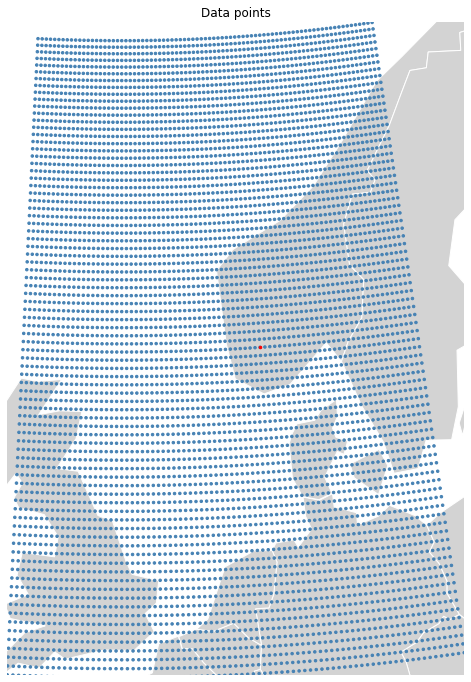

In [93]:
latlon = pd.DataFrame(itertools.product(lats, lons),columns=["lat","lon"])
gdf_select = geopandas.GeoDataFrame(latlon, geometry=[shapely.geometry.Point(x, y) for x, y in zip(latlon.lon, latlon.lat)])
world = geopandas.read_file(geoplot.datasets.get_path('world'))
proj = geoplot.crs.AlbersEqualArea()
extent = gdf_select.total_bounds
ax = geoplot.polyplot(world, projection=proj, figsize=(12,12),facecolor="lightgray",edgecolor="white")
geoplot.pointplot(gdf_select,marker='.',ax=ax,projection=proj);
geoplot.pointplot(gdf_select.loc[[3450]],marker='.',color="red",ax=ax,extent=extent);
plt.title("Data points");

In [96]:
latlon.loc[3450]

lat                   59.5
lon                    7.0
geometry    POINT (7 59.5)
Name: 3450, dtype: object

Text(0.5, 1.0, '(lat,lon)=(50.0,-4.75)')

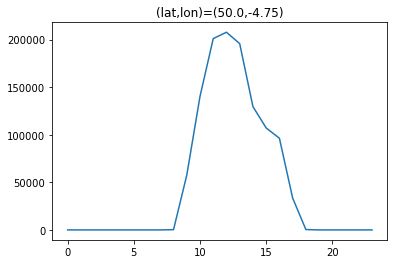

In [33]:

ilat=80
ilon=1
plt.plot(ssrd[:,1,1])
plt.title("(lat,lon)=({},{})".format(lats[ilat],lons[ilon]))

In [98]:
df4s[12].head()

-5.00      -4.75      -4.50      -4.25      -4.00      -3.75   \
70.00   5.883742   5.724947   5.566153   6.502203   7.647193   9.210061   
69.75   1.972391   1.855384   2.808149   5.223492   6.828149   8.391018   
69.50   5.256923   6.309979   7.363035   9.878668  12.385945  15.361246   
69.25   9.744947  12.143575  14.751142  18.219541  21.545860  24.888895   
69.00  15.695549  19.080372  22.448480  26.259540  30.062242  33.814799   

          -3.50      -3.25      -3.00      -2.75   ...      12.75      13.00  \
70.00  15.453179  19.389603  22.540413  25.616006  ...  -7.145737  -6.702785   
69.75  14.717711  21.036048  27.128729  32.853676  ... -10.171184  -9.686444   
69.50  20.659956  26.827856  32.953967  38.720703  ...  -8.783824 -10.864864   
69.25  29.652720  34.416545  38.762491  41.971804  ...  -5.691517  -8.482951   
69.00  37.124403  40.308644  43.467812  44.955463  ...  -2.457131  -6.351766   

           13.25      13.50      13.75      14.00      14.25      14.50  \
70.00  -5.942245  -5.047983  -3.058877  -1.011268   1.086486   3.142453   
69.75  -9.226777 -10.187899  -9.669729  -7.555259  -5.440789  -3.359750   
69.50 -11.934635 -13.012764 -12.603242 -12.210435 -12.803824  -9.887026   
69.25 -11.257670 -14.349978 -15.628689 -16.940830 -18.236256 -15.077088   
69.00 -10.329978 -14.308190 -15.520040 -16.690102 -17.901952 -14.383408   

           14.75     15.00  
70.00   4.696964  6.042536  
69.75  -1.245281  1.387360  
69.50  -7.204240 -4.513097  
69.25 -11.942992 -8.675176  
69.00 -10.848148 -7.287816  

[5 rows x 81 columns]

In [97]:
@interact
def show_rad(hour=(1,len(df4s),1)):
    df4=df4s[hour]
    plt.figure(figsize=(16,10))
    proj=cartopy.crs.AlbersEqualArea(central_longitude=10,central_latitude=60)
    ax = plt.subplot(111, projection=proj)
    mm = ax.pcolormesh(df4.columns,df4.index,df4,vmin=0,vmax=1200,
                       transform=cartopy.crs.PlateCarree())
    cbar=plt.colorbar(mm,ax=ax)
    ax.coastlines(resolution='50m')
    #ax.gridlines(draw_labels=False)
    plt.title("{} ({})".format(ssrd.long_name,jd[hour]))
    plt.show()

NameError: name 'interact' is not defined

In [591]:
delta_t/3600

1.0

## Solar radiation

Note: radiation data are given as forecasts at 12h intervals, with 1h steps

In [329]:
#da = xr.open_dataarray("data2/era5data_lat=63.5_lon=8.0_year=2020.grib",engine="cfgrib",
#                       backend_kwargs={'filter_by_keys': {'shortName': 'v100'}})

In [335]:
ds_ssrd=xr.open_mfdataset("data2/era5data_lat=63.5_lon=8.0_year=*.grib",engine="cfgrib",
                  backend_kwargs={'filter_by_keys': {'shortName': 'ssrd'}})
ds_fdir=xr.open_mfdataset("data2/era5data_lat=63.5_lon=8.0_year=*.grib",engine="cfgrib",
                  backend_kwargs={'filter_by_keys': {'shortName': 'fdir'}})

In [336]:
df_rad = pd.DataFrame()
df_rad["fdir"] = dataarray_to_dataframe(ds_fdir.fdir)
df_rad["ssdr"] = dataarray_to_dataframe(ds_ssrd.ssrd)
df_rad["diffuse"] = df_rad["ssdr"]-df_rad["fdir"]

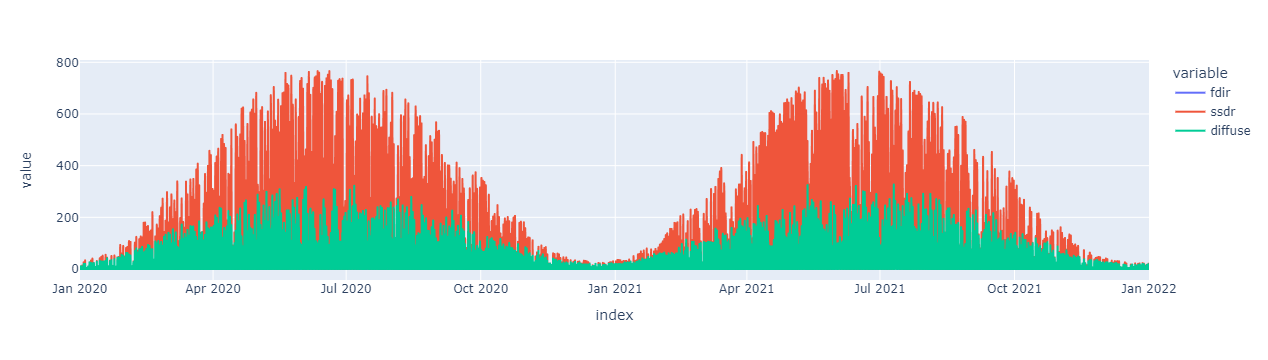

In [357]:
px.line(df_rad/3600)

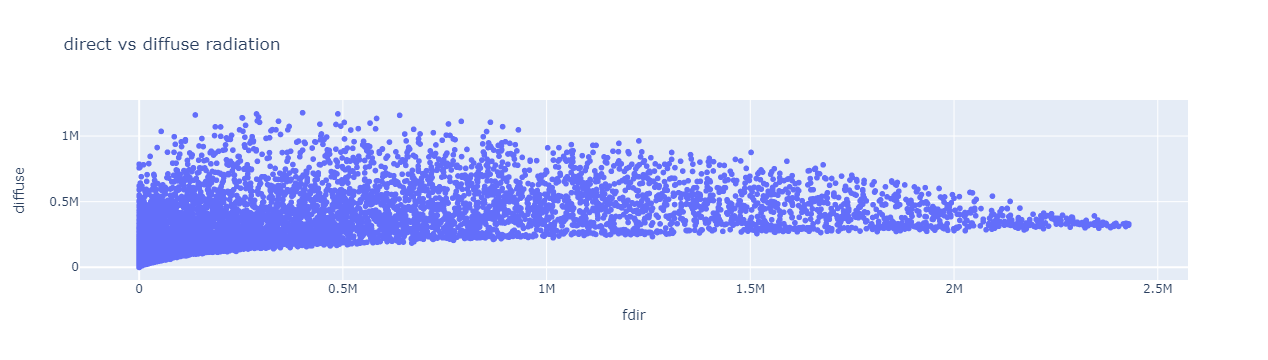

In [340]:
px.scatter(df_rad,x="fdir",y="diffuse",title="direct vs diffuse radiation")

In [ ]:
# ssrd (surface solar radiation downwards, direct+diffuse), 
# fdir (total sky direct solar radiation at surface)
# dsrp (direct solar radiation onto sufrace perpendicular to sun)
# ssrd-fdir = diffuse

In [356]:
import energy_timeseries

ModuleNotFoundError: No module named 'energy_timeseries'

In [354]:
utils.compute_solar_power(df_rad, lat=63.5, lon=8.0, panel_slope=0, panel_azimuth=180,albedo=0.2, eta_rad_to_el=1.0,tracking=None)

NameError: name 'solar' is not defined